In [3]:
# Required Libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from skimage import io, color, filters, exposure, feature
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Project directories
PROJECT_DIR = r"C:\Users\David\programmindAssignment2"
IMAGE_DIR = os.path.join(PROJECT_DIR, "Images")
ANNOTATION_DIR = os.path.join(PROJECT_DIR, "Annotation")
PROCESSED_DIR = os.path.join(PROJECT_DIR, "ProcessedImages")
RESULTS_DIR = os.path.join(PROJECT_DIR, "Results")

# Create necessary directories
for dir_path in [PROCESSED_DIR, RESULTS_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("Available dog breeds:")
breed_folders = [f for f in os.listdir(IMAGE_DIR) if os.path.isdir(os.path.join(IMAGE_DIR, f))]
for breed in breed_folders:
    n_images = len(glob.glob(os.path.join(IMAGE_DIR, breed, "*.jpg")))
    print(f"{breed}: {n_images} images")

Available dog breeds:
n02091032-Italian_greyhound: 182 images
n02096177-cairn: 197 images
n02106030-collie: 153 images
n02107908-Appenzeller: 151 images


Starting image processing...
Input image directory: C:\Users\David\programmindAssignment2\Images
Input annotation directory: C:\Users\David\programmindAssignment2\Annotation
Output directory: C:\Users\David\programmindAssignment2\ProcessedImages

Processing breed: n02091032-Italian_greyhound
Found 182 images to process
Processed 210 images for n02091032-Italian_greyhound
Completed n02091032-Italian_greyhound: 216 images processed

Processing breed: n02096177-cairn
Found 197 images to process
Processed 200 images for n02096177-cairn
Completed n02096177-cairn: 205 images processed

Processing breed: n02106030-collie
Found 153 images to process
Processed 160 images for n02106030-collie
Completed n02106030-collie: 169 images processed

Processing breed: n02107908-Appenzeller
Found 151 images to process
Processed 160 images for n02107908-Appenzeller
Completed n02107908-Appenzeller: 164 images processed

Processing Summary:
----------------------------------------
n02091032-Italian_greyhound

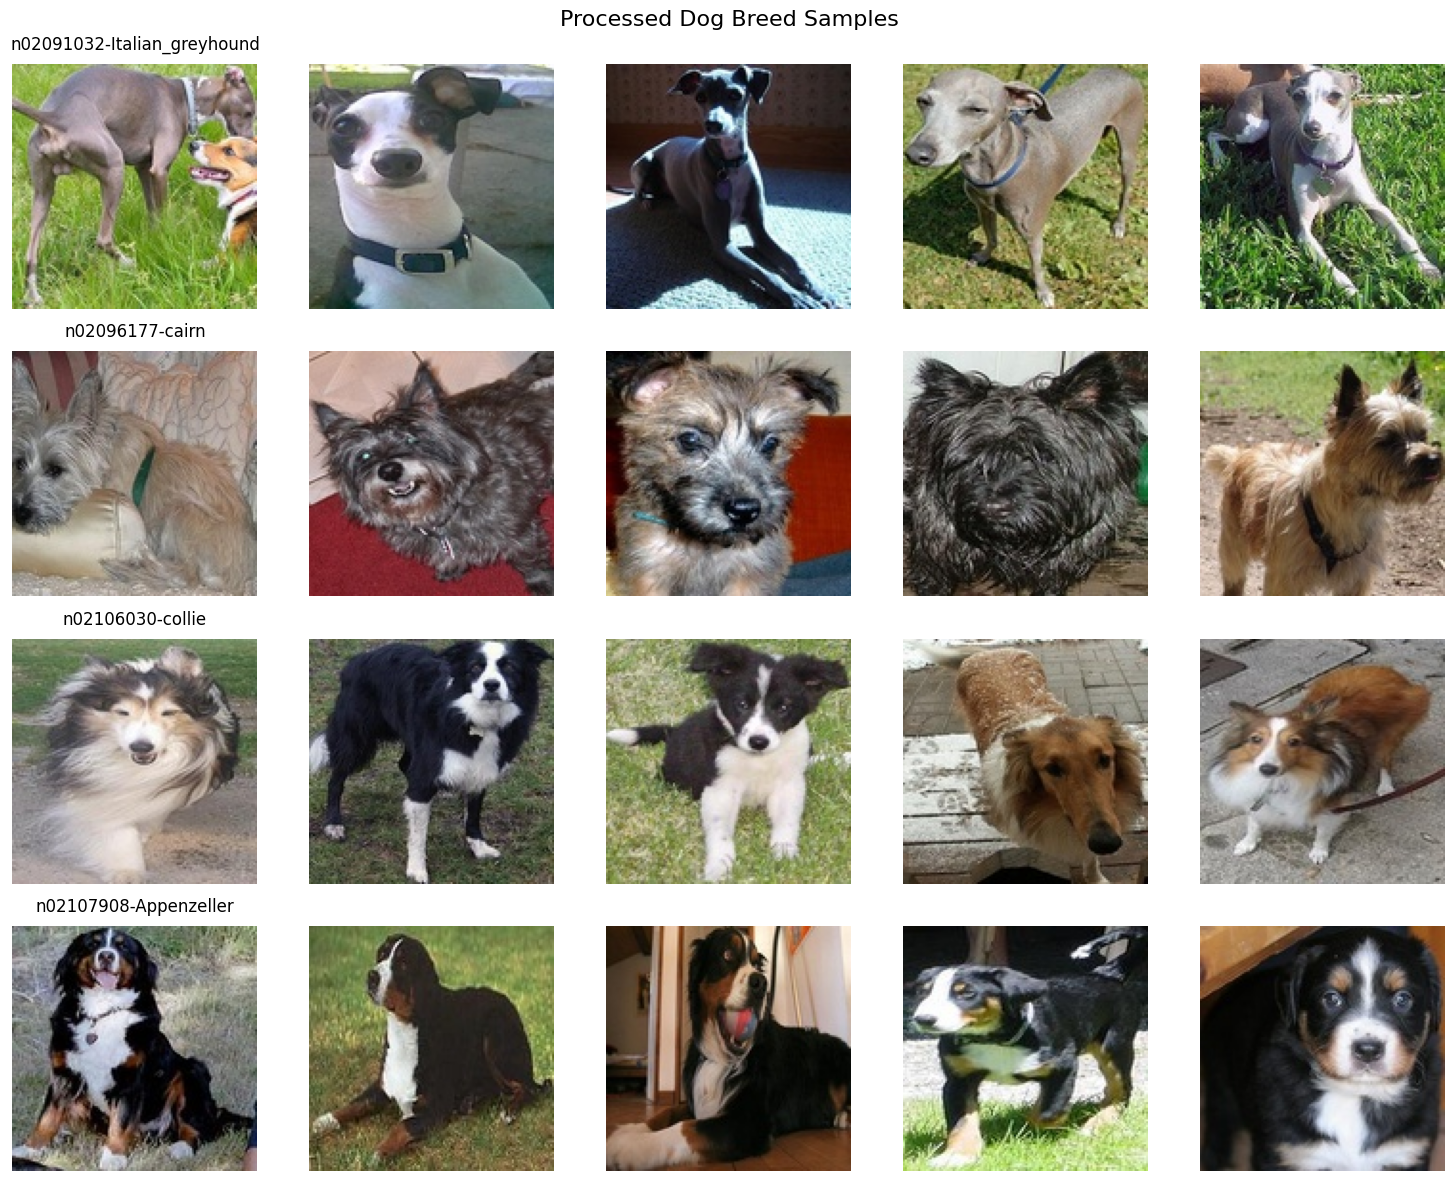


Visualization saved to C:\Users\David\programmindAssignment2\Results\processed_samples.png


In [7]:
def process_dog_breeds(image_base_dir, annotation_base_dir, output_base_dir, target_size=(128, 128)):
    """
    Process all dog breed images and their annotations.
    
    Args:
        image_base_dir: Base directory containing dog breed image folders
        annotation_base_dir: Base directory containing dog breed annotation folders
        output_base_dir: Base directory where processed images will be saved
        target_size: Target size for resized images (default: 128x128)
    """
    # Create output base directory
    Path(output_base_dir).mkdir(parents=True, exist_ok=True)
    
    # Get list of breed folders
    breed_folders = [f for f in os.listdir(image_base_dir) if os.path.isdir(os.path.join(image_base_dir, f))]
    
    total_processed = {}
    processed_image_paths = {}  # Store paths of processed images for each breed
    
    for breed in breed_folders:
        print(f"\nProcessing breed: {breed}")
        
        # Setup paths
        breed_output_dir = os.path.join(output_base_dir, breed)
        Path(breed_output_dir).mkdir(parents=True, exist_ok=True)
        
        image_dir = os.path.join(image_base_dir, breed)
        annotation_dir = os.path.join(annotation_base_dir, breed)
        
        # Get all images
        image_files = glob.glob(os.path.join(image_dir, "*.jpg"))
        processed_count = 0
        processed_image_paths[breed] = []  # Initialize list for this breed
        
        print(f"Found {len(image_files)} images to process")
        
        for image_path in image_files:
            # Get corresponding annotation file
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            annotation_path = os.path.join(annotation_dir, f"{image_name}.xml")
            
            if not os.path.exists(annotation_path):
                print(f"Warning: Missing annotation for {image_name}")
                continue
            
            try:
                # Parse annotation XML
                tree = ET.parse(annotation_path)
                root = tree.getroot()
                objects = root.findall('object')
                
                if not objects:
                    print(f"Warning: No objects found in annotation for {image_name}")
                    continue
                
                # Open and process image
                with Image.open(image_path) as img:
                    # Process each bounding box
                    for idx, obj in enumerate(objects):
                        bndbox = obj.find('bndbox')
                        bbox = [
                            int(bndbox.find('xmin').text),
                            int(bndbox.find('ymin').text),
                            int(bndbox.find('xmax').text),
                            int(bndbox.find('ymax').text)
                        ]
                        
                        # Crop and resize
                        cropped = img.crop(bbox)
                        resized = cropped.resize(target_size, Image.LANCZOS)
                        resized = resized.convert('RGB')
                        
                        # Save processed image
                        output_path = os.path.join(breed_output_dir, f"{image_name}_{idx}.jpg")
                        resized.save(output_path, 'JPEG', quality=95)
                        processed_image_paths[breed].append(output_path)
                        processed_count += 1
                        
                if processed_count % 10 == 0:
                    print(f"Processed {processed_count} images for {breed}", end='\r')
                    
            except Exception as e:
                print(f"Error processing {image_name}: {str(e)}")
                continue
        
        total_processed[breed] = processed_count
        print(f"\nCompleted {breed}: {processed_count} images processed")
    
    return total_processed, processed_image_paths

def visualize_processed_samples(processed_image_paths, samples_per_breed=5):
    """
    Visualize random samples of processed images from each breed.
    
    Args:
        processed_image_paths: Dictionary containing lists of processed image paths for each breed
        samples_per_breed: Number of samples to display for each breed
    """
    num_breeds = len(processed_image_paths)
    
    # Calculate grid dimensions
    fig = plt.figure(figsize=(15, 3 * num_breeds))
    fig.suptitle("Processed Dog Breed Samples", fontsize=16)
    
    for idx, (breed, paths) in enumerate(processed_image_paths.items()):
        # Select random samples
        sample_paths = random.sample(paths, min(samples_per_breed, len(paths)))
        
        for j, path in enumerate(sample_paths):
            plt.subplot(num_breeds, samples_per_breed, idx * samples_per_breed + j + 1)
            img = Image.open(path)
            plt.imshow(np.array(img))
            plt.axis('off')
            if j == 0:  # Only add breed name to first image in row
                plt.title(f"{breed}", pad=10)
    
    plt.tight_layout()
    return fig

# Main execution
if __name__ == "__main__":
    # Use the paths from our setup
    image_base_dir = IMAGE_DIR
    annotation_base_dir = ANNOTATION_DIR
    output_base_dir = PROCESSED_DIR
    
    print("Starting image processing...")
    print(f"Input image directory: {image_base_dir}")
    print(f"Input annotation directory: {annotation_base_dir}")
    print(f"Output directory: {output_base_dir}")
    
    # Process the images and get results
    results, processed_paths = process_dog_breeds(image_base_dir, annotation_base_dir, output_base_dir)
    
    # Print summary
    print("\nProcessing Summary:")
    print("-" * 40)
    total_images = 0
    for breed, count in results.items():
        print(f"{breed}: {count} images")
        total_images += count
    print("-" * 40)
    print(f"Total processed images: {total_images}")
    
    # Visualize samples
    fig = visualize_processed_samples(processed_paths)
    plt.show()
    
    # Save the visualization
    fig.savefig(os.path.join(RESULTS_DIR, 'processed_samples.png'))
    print(f"\nVisualization saved to {os.path.join(RESULTS_DIR, 'processed_samples.png')}")

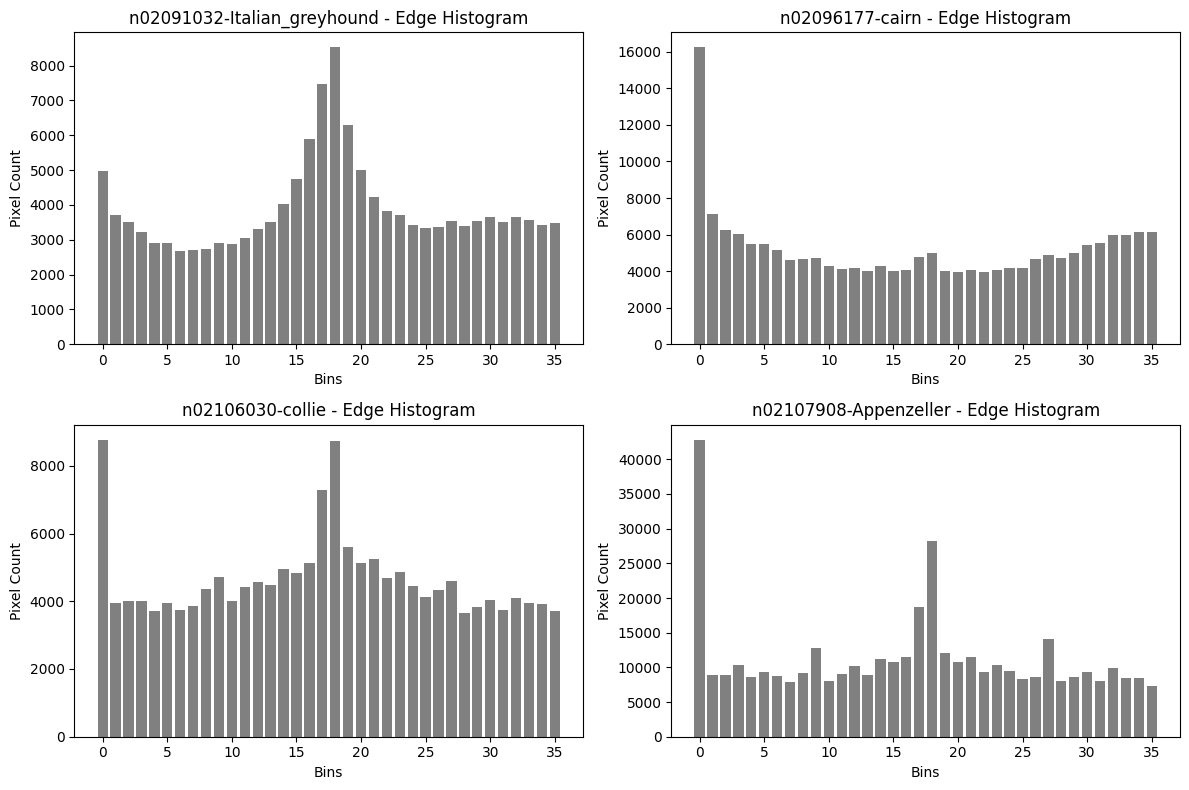

Euclidean Distance: 16162.94261574915
Manhattan Distance: 71556.0
Cosine Distance: 0.10990427038087769


In [17]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
import os

# Load a sample image from each breed for edge histogram extraction
sample_images = [os.path.join(IMAGE_DIR, breed_folders[i], os.listdir(os.path.join(IMAGE_DIR, breed_folders[i]))[0]) 
                 for i in range(len(breed_folders))]

# Step 1: Function to compute the edge gradient angle and histogram
def compute_edge_histogram(image_path):
    # Load image and convert to grayscale
    image = io.imread(image_path)
    gray_image = color.rgb2gray(image)
    
    # Compute the horizontal and vertical Sobel filters
    sobel_h = filters.sobel_h(gray_image)
    sobel_v = filters.sobel_v(gray_image)
    
    # Calculate gradient angle for each pixel
    gradient_angle = np.arctan2(sobel_v, sobel_h) % np.pi
    
    # Compute a 36-bin histogram of the gradient angles
    hist, bin_edges = exposure.histogram(gradient_angle, nbins=36)
    
    return hist

# Step 2: Plot the edge histogram for each breed sample
edge_histograms = []
plt.figure(figsize=(12, 8))
for i, image_path in enumerate(sample_images):
    hist = compute_edge_histogram(image_path)
    edge_histograms.append(hist)
    
    # Plot histogram
    plt.subplot(2, 2, i + 1)
    plt.bar(range(36), hist, color='gray')
    plt.title(f"{breed_folders[i]} - Edge Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")

plt.tight_layout()
plt.show()

# Step 3: Similarity Measurements
# Select two edge histograms to compare
hist1 = edge_histograms[0]
hist2 = edge_histograms[1]

# Calculate Euclidean, Manhattan, and Cosine distances
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

# Reshape histograms for pairwise distance calculations
hist1_reshaped = hist1.reshape(1, -1)
hist2_reshaped = hist2.reshape(1, -1)

# Calculate distances
euclidean_dist = euclidean_distances(hist1_reshaped, hist2_reshaped)[0][0]
manhattan_dist = manhattan_distances(hist1_reshaped, hist2_reshaped)[0][0]
cosine_dist = cosine_distances(hist1_reshaped, hist2_reshaped)[0][0]

print(f"Euclidean Distance: {euclidean_dist}")
print(f"Manhattan Distance: {manhattan_dist}")
print(f"Cosine Distance: {cosine_dist}")


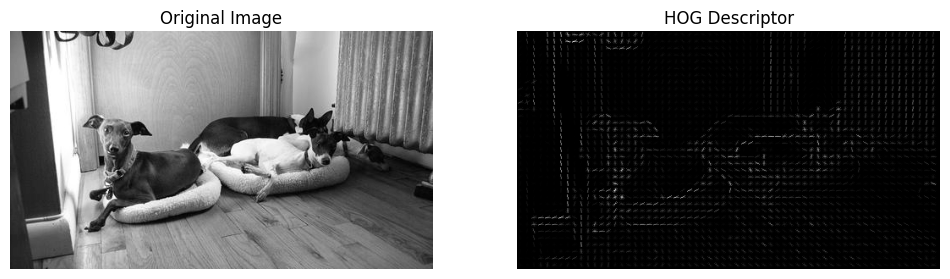

In [18]:
# Required Libraries
from skimage.feature import hog
from skimage import exposure

# Choose one sample image for HOG descriptor calculation (e.g., the first breed)
sample_image_path = sample_images[0]

# Step 1: Load and preprocess the image
image = io.imread(sample_image_path)
gray_image = color.rgb2gray(image)

# Step 2: Compute HOG descriptor
hog_descriptor, hog_image = hog(
    gray_image, 
    orientations=9,         # Number of gradient bins
    pixels_per_cell=(8, 8), # Size of cell in pixels
    cells_per_block=(2, 2), # Number of cells in each block
    visualize=True,         # Return the image for visualization
    feature_vector=True     # Flatten the HOG features into a single vector
)

# Step 3: Visualize the original and HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.imshow(gray_image, cmap=plt.cm.gray)
ax1.set_title("Original Image")
ax1.axis("off")

# Rescale HOG image for better visibility
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title("HOG Descriptor")
ax2.axis("off")

plt.show()


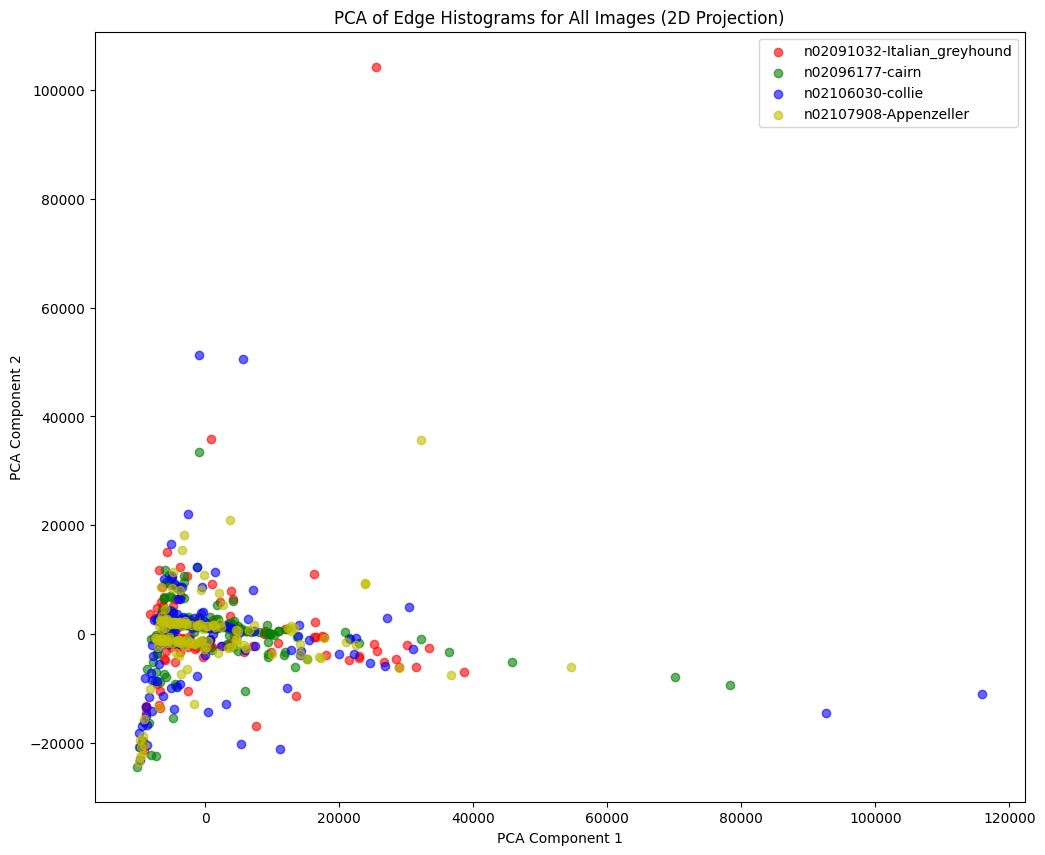

In [20]:
# Step 1: Compute edge histograms for all images across the selected breeds
edge_histograms_all = []
labels = []

for breed in breed_folders[:4]:  # Assuming the first four folders correspond to the selected breeds
    breed_path = os.path.join(IMAGE_DIR, breed)
    images = glob.glob(os.path.join(breed_path, "*.jpg"))  # All images in the breed folder
    
    for image_path in images:
        hist = compute_edge_histogram(image_path)
        edge_histograms_all.append(hist)
        labels.append(breed)  # Assign breed label to each histogram

edge_histograms_all = np.array(edge_histograms_all)

# Step 2: Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
edge_histograms_2d = pca.fit_transform(edge_histograms_all)

# Step 3: Plot the PCA results with all images
plt.figure(figsize=(12, 10))
colors = ['r', 'g', 'b', 'y']  # Assign a color to each breed

for i, breed in enumerate(breed_folders[:4]):
    breed_indices = [j for j, x in enumerate(labels) if x == breed]
    plt.scatter(edge_histograms_2d[breed_indices, 0], edge_histograms_2d[breed_indices, 1],
                color=colors[i], label=breed, alpha=0.6)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Edge Histograms for All Images (2D Projection)")
plt.legend()
plt.show()


In [34]:
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# File paths
train_path = 'Data/train.json'
test_path = 'Data/test.json'
validation_path = 'Data/validation.json'

def load_json_lines(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load the datasets
train_data = load_json_lines(train_path)
test_data = load_json_lines(test_path)
validation_data = load_json_lines(validation_path)

print(f"Train Data: {len(train_data)} records")
print(f"Test Data: {len(test_data)} records")
print(f"Validation Data: {len(validation_data)} records")

# Extracting the Tweets for vectorization
train_texts = [entry['Tweet'] for entry in train_data]

# Step 4: Count Vectorization
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(train_texts)

print(f"Count Vectorization shape: {X_train_count.shape}")

# Step 4: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)

print(f"TF-IDF Vectorization shape: {X_train_tfidf.shape}")

# Example of how to access the feature names
print(f"Count Vectorizer features: {count_vectorizer.get_feature_names_out()}")
print(f"TF-IDF Vectorizer features: {tfidf_vectorizer.get_feature_names_out()}")


Train Data: 3000 records
Test Data: 1500 records
Validation Data: 400 records
Count Vectorization shape: (3000, 9755)
TF-IDF Vectorization shape: (3000, 9755)
Count Vectorizer features: ['00' '000' '00pm' ... 'óg' 'アニメ' '화양연화']
TF-IDF Vectorizer features: ['00' '000' '00pm' ... 'óg' 'アニメ' '화양연화']


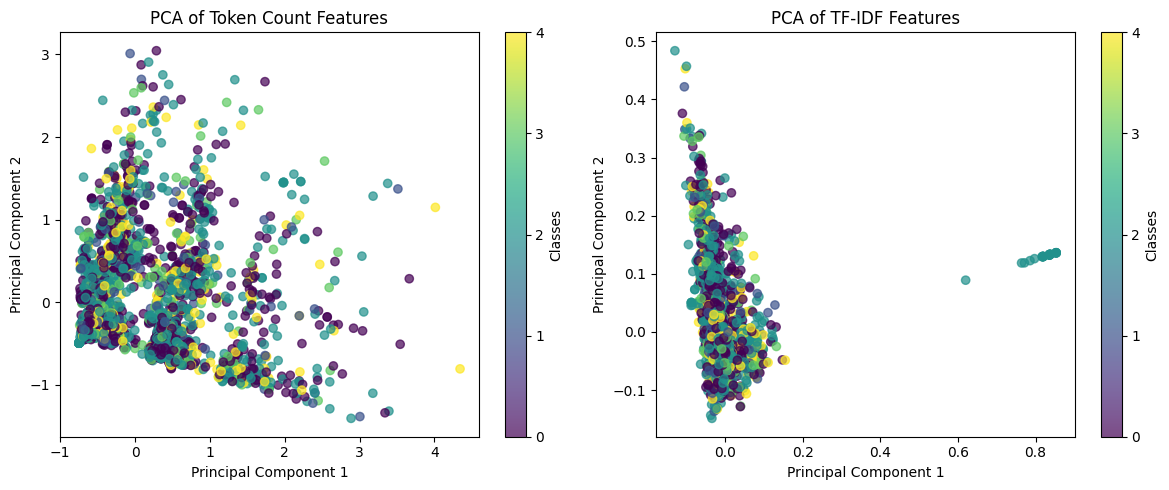

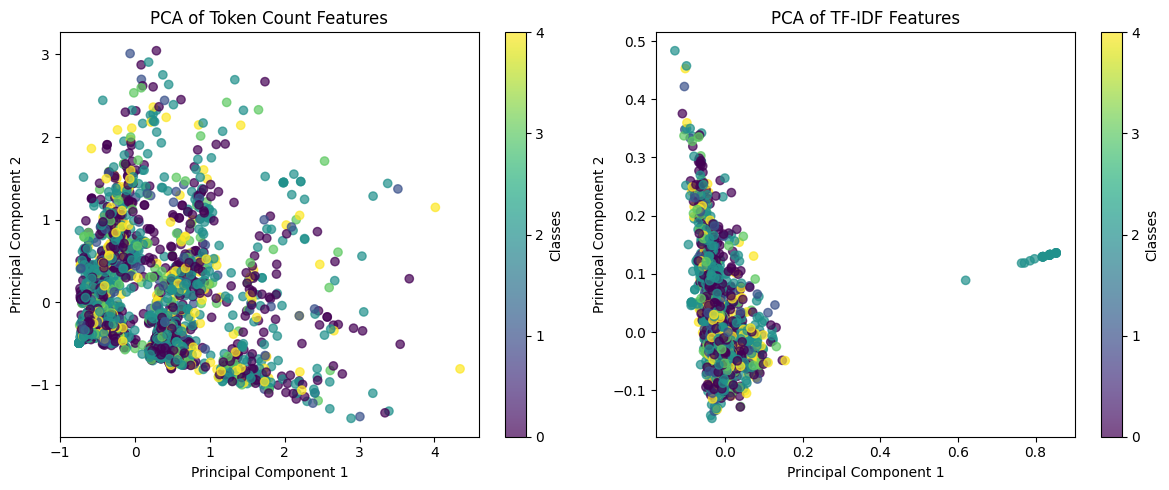

In [37]:
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# File path for training data
train_path = 'Data/train.json'

def load_json_lines(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load the training dataset
train_data = load_json_lines(train_path)

# Extracting the Tweets and labels for vectorization
train_texts = [entry['Tweet'] for entry in train_data]

# Creating labels based on emotional indicators (custom logic)
train_labels = []
for entry in train_data:
    if entry['joy']:
        train_labels.append('Joy')
    elif entry['anger']:
        train_labels.append('Anger')
    elif entry['sadness']:
        train_labels.append('Sadness')
    elif entry['fear']:
        train_labels.append('Fear')
    else:
        train_labels.append('Other')  # For cases that don't fall into the specified classes

# Convert categorical labels to numeric values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# 1. Count Vectorization
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(train_texts)

# 2. TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)

# 3. Dimensionality Reduction using PCA
pca = PCA(n_components=2)
X_counts_pca = pca.fit_transform(X_train_counts.toarray())
X_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())

# 4. Plotting the results
plt.figure(figsize=(12, 5))

# Plot for Count Vectorization
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_counts_pca[:, 0], X_counts_pca[:, 1], c=train_labels_encoded, cmap='viridis', alpha=0.7)
plt.title('PCA of Token Count Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter1, ticks=range(len(label_encoder.classes_)), label='Classes', format='%d')

# Plot for TF-IDF Vectorization
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=train_labels_encoded, cmap='viridis', alpha=0.7)
plt.title('PCA of TF-IDF Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter2, ticks=range(len(label_encoder.classes_)), label='Classes', format='%d')

plt.tight_layout()
plt.show()
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# File path for training data
train_path = 'Data/train.json'

def load_json_lines(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load the training dataset
train_data = load_json_lines(train_path)

# Extracting the Tweets and labels for vectorization
train_texts = [entry['Tweet'] for entry in train_data]

# Creating labels based on emotional indicators (custom logic)
train_labels = []
for entry in train_data:
    if entry['joy']:
        train_labels.append('Joy')
    elif entry['anger']:
        train_labels.append('Anger')
    elif entry['sadness']:
        train_labels.append('Sadness')
    elif entry['fear']:
        train_labels.append('Fear')
    else:
        train_labels.append('Other')  # For cases that don't fall into the specified classes

# Convert categorical labels to numeric values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# 1. Count Vectorization
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(train_texts)

# 2. TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)

# 3. Dimensionality Reduction using PCA
pca = PCA(n_components=2)
X_counts_pca = pca.fit_transform(X_train_counts.toarray())
X_tfidf_pca = pca.fit_transform(X_train_tfidf.toarray())

# 4. Plotting the results
plt.figure(figsize=(12, 5))

# Plot for Count Vectorization
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_counts_pca[:, 0], X_counts_pca[:, 1], c=train_labels_encoded, cmap='viridis', alpha=0.7)
plt.title('PCA of Token Count Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter1, ticks=range(len(label_encoder.classes_)), label='Classes', format='%d')

# Plot for TF-IDF Vectorization
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c=train_labels_encoded, cmap='viridis', alpha=0.7)
plt.title('PCA of TF-IDF Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter2, ticks=range(len(label_encoder.classes_)), label='Classes', format='%d')

plt.tight_layout()
plt.show()
